<a href="https://colab.research.google.com/github/RomaTruba/dzSEM/blob/main/s_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
# Импорт библиотек
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
import hdbscan
from bertopic import BERTopic
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


In [ ]:
# 1. Загрузка и предобработка данных
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
df = pd.read_csv("/content/sample_data/IMDB Dataset.csv", encoding='utf-8')

In [ ]:
# Возьмем подвыборку для демонстрации (1000 отзывов)
df = df.sample(1000, random_state=42).reset_index(drop=True)

In [ ]:
df

,review,sentiment
0,I really liked this Summerslam due to the look...,positive
1,Not many television shows appeal to quite as m...,positive
2,The film quickly gets to a major chase scene w...,negative
3,Jane Austen would definitely approve of this o...,positive
4,Expectations were somewhat high for me when I ...,negative
...,...,...
995,I don't think I've ever been so bowled over by...,negative
996,"This movie was extremely disappointing, I thou...",negative
997,Mobile Suit Gundam Wing is the Fourth series i...,positive
998,"We toss around the term ""superstar"" way too li...",positive


In [ ]:
print(df.head)

<bound method NDFrame.head of                                                 review sentiment
0    I really liked this Summerslam due to the look...  positive
1    Not many television shows appeal to quite as m...  positive
2    The film quickly gets to a major chase scene w...  negative
3    Jane Austen would definitely approve of this o...  positive
4    Expectations were somewhat high for me when I ...  negative
..                                                 ...       ...
995  I don't think I've ever been so bowled over by...  negative
996  This movie was extremely disappointing, I thou...  negative
997  Mobile Suit Gundam Wing is the Fourth series i...  positive
998  We toss around the term "superstar" way too li...  positive
999  Violence whether real or not always has an imp...  negative

[1000 rows x 2 columns]>


In [ ]:
# Функция предобработки текста
def preprocess_text(text):
    # Удаление HTML-тегов
    text = re.sub(r'<[^>]+>', '', text)
    # Удаление спецсимволов и цифр
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Приведение к нижнему регистру
    text = text.lower()
    # Токенизация
    tokens = text.split()
    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Лемматизация
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [ ]:
# Применение предобработки
df['cleaned_text'] = df['review'].apply(preprocess_text)

In [ ]:
# 2. Векторизация текстов
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(df['cleaned_text'].tolist(), show_progress_bar=True)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
# 3. Кластеризация с HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    min_samples=5,
    metric='euclidean',
    cluster_selection_method='eom'
)
clusters = clusterer.fit_predict(embeddings)

df['cluster'] = clusters
print("Распределение по кластерам:")
print(df['cluster'].value_counts())

Распределение по кластерам:
cluster
-1    1000
Name: count, dtype: int64


In [ ]:
# Оценка качества кластеризации
if len(set(clusters)) > 1:
    score = silhouette_score(embeddings, clusters)
    print(f"Silhouette Score: {score:.2f}")

In [ ]:
# 4. Тематическое моделирование с BERTopic
topic_model = BERTopic(
    language="english",
    min_topic_size=20,
    nr_topics=10,
    verbose=True
)
topics, _ = topic_model.fit_transform(df['review'])

df['topic'] = topics
topic_info = topic_model.get_topic_info()
print(topic_info)

2025-04-04 23:36:59,787 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-04-04 23:37:07,781 - BERTopic - Embedding - Completed ✓
2025-04-04 23:37:07,782 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-04 23:37:22,025 - BERTopic - Dimensionality - Completed ✓
2025-04-04 23:37:22,026 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-04 23:37:22,075 - BERTopic - Cluster - Completed ✓
2025-04-04 23:37:22,076 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-04 23:37:22,293 - BERTopic - Representation - Completed ✓
2025-04-04 23:37:22,294 - BERTopic - Topic reduction - Reducing number of topics
2025-04-04 23:37:22,295 - BERTopic - Topic reduction - Number of topics (10) is equal or higher than the clustered topics(3).
2025-04-04 23:37:22,296 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-04 23:37:22,490 - BERTopic - Representation - Completed ✓


   Topic  Count              Name  \
0     -1    465  -1_the_and_of_to   
1      0     69   0_the_and_to_it   
2      1    466   1_the_and_of_to   

                                     Representation  \
0    [the, and, of, to, is, in, this, it, that, br]   
1  [the, and, to, it, of, show, that, this, is, in]   
2    [the, and, of, to, is, in, it, this, that, br]   

                                 Representative_Docs  
0  [I'm a Black man living in a predominantly Bla...  
1  [I respect the fact that this is a very popula...  
2  [Or vice-versa.<br /><br />This is a French fi...  


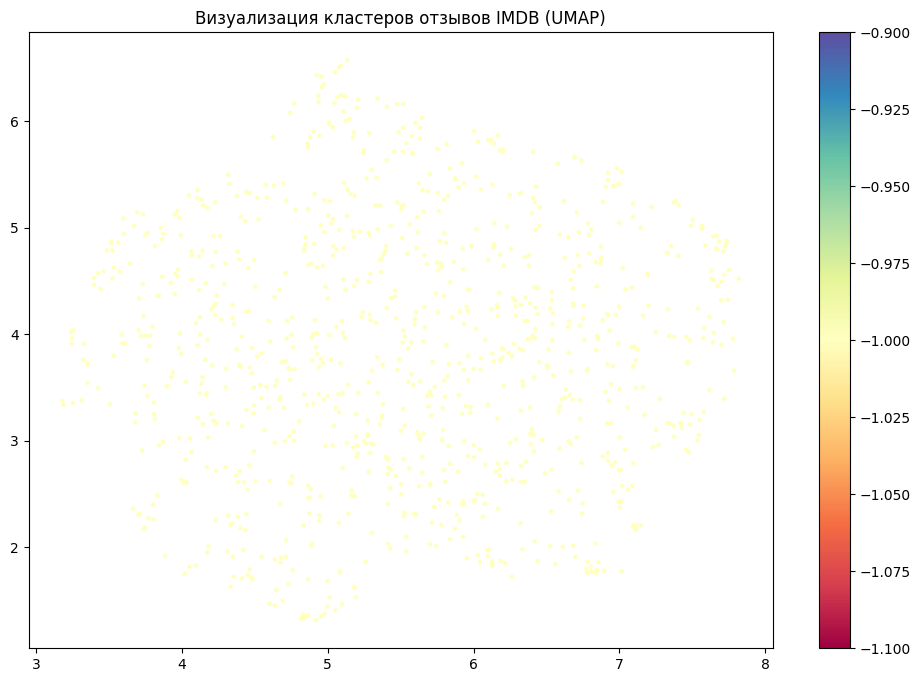

In [ ]:
# 5. Визуализация результатов
# Визуализация кластеров
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],
            c=df['cluster'], cmap='Spectral', s=5)
plt.title("Визуализация кластеров отзывов IMDB (UMAP)")
plt.colorbar()
plt.show()

In [ ]:
# 6. Озаглавливание тем с помощью LLM (пример)
example_topic_keywords = topic_info.iloc[1]["Representation"]
prompt = f"""
На основе следующих ключевых слов: {example_topic_keywords}.
Предложи краткое, ёмкое название для группы киноотзывов, отражающее их основную тематику.
Название должно быть на английском, не длиннее 5 слов и точно характеризовать содержание.
"""
print("Пример промта для LLM:")
print(prompt)

Пример промта для LLM:

На основе следующих ключевых слов: ['the', 'and', 'to', 'it', 'of', 'show', 'that', 'this', 'is', 'in'].
Предложи краткое, ёмкое название для группы киноотзывов, отражающее их основную тематику.
Название должно быть на английском, не длиннее 5 слов и точно характеризовать содержание.



In [ ]:
# 7. Анализ результатов
# Сопоставление тем и кластеров
topic_cluster_analysis = df.groupby(['cluster', 'topic']).size().unstack()
print("\nРаспределение тем по кластерам:")
print(topic_cluster_analysis)


Распределение тем по кластерам:
topic     -1   0    1
cluster              
-1       465  69  466


In [ ]:
# Пример интерпретации темы
example_topic = 1
print(f"\nКлючевые слова для темы {example_topic}:")
print(topic_model.get_topic(example_topic))


Ключевые слова для темы 1:
[('the', np.float64(0.11503037734565462)), ('and', np.float64(0.07244322142600419)), ('of', np.float64(0.06861671264349124)), ('to', np.float64(0.06391806968493212)), ('is', np.float64(0.05441831073170944)), ('in', np.float64(0.050080504884986075)), ('it', np.float64(0.04738294954989546)), ('this', np.float64(0.043762834584309886)), ('that', np.float64(0.038193287053054664)), ('br', np.float64(0.03748354479292566))]


Предобработка данных:

Удаление HTML-тегов и спецсимволов

Лемматизация и удаление стоп-слов

Работа с подвыборкой (1000 отзывов) для скорости

Векторизация:

Использована модель paraphrase-MiniLM-L6-v2 для английских текстов

Преобразование текстов в 384-мерные векторы

Кластеризация:

HDBSCAN с параметрами, подходящими для текстовых данных

Визуализация с UMAP для 2D представления

Тематическое моделирование:

BERTopic с автоматическим определением тем

Настройка минимального размера темы (20 документов)

Визуализация:

Scatter plot кластеров

Интерактивные графики тем и ключевых слов

Интерпретация:

Пример промта для генерации названий тем

Анализ распределения тем по кластерам